# Ramsey-Cass-Koopmans model

Ramsey model from Chapter 2 of D. Romer's *Advanced Economics* looks as follows...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    \dot{c}(t) =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t)
\end{align}
...with boundary conditions...
\begin{align}
    k(0) =& k_0 \\
    lim_{t\rightarrow \infty} c(t) =& c^*
\end{align}

...where...

* Elasticity of output with respect to catpial: $0 < \alpha < 1$
* Coefficient of relative risk aversion: $0 < \theta$
* Discount rate: $0 < \rho$
* Breakeven investment: $0 < g + n + \delta$
* Convergent lifetime utility: $0 < \rho - n - (1 - \theta)g$

Note that we are assuming two things...

1. Cobb-Douglas production
2. Constant Relative Risk Aversion (CRRA) preferences



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sympy as sym

import pycollocation

In [3]:
# define some variables
t, k, c = sym.symbols("t, k, c")

In [4]:
# define some production parameters
alpha, delta = sym.symbols("alpha, delta")

# define growth rates
g, n = sym.symbols("g, n")

# define some preference parameters
theta, rho = sym.symbols("theta, rho")

In [5]:
# define a production function
def intensive_output(capital, alpha):
    """
    Intensive output is a function of capital (per unit effective labor)
    and model parameters.
    
    """
    return capital**alpha

# call with symbolic input and get symbolic result!
print intensive_output(k, alpha)

k**alpha


In [6]:
# call with numeric input and get numeric result...
print intensive_output(10.0, 0.33)

2.1379620895


In [7]:
# also works with arrays!
ks = np.linspace(0, 100, 10)
print intensive_output(ks, 0.33)

[ 0.          2.21360421  2.7825301   3.18089978  3.49767755  3.76495746
  3.99843357  4.20709506  4.39662746  4.5708819 ]


In [8]:
# define a flow utility function
def flow_utility(c, theta):
    """Flow utility from consumption (per unit effective labor)."""
    return (c**(1 - theta) - 1) / (1 - theta)

# symbolic inputs give symbolic outputs...
print flow_utility(c, theta)

(c**(-theta + 1) - 1)/(-theta + 1)


In [9]:
# define the equation of motion for capital (per unit effective labor)
def equation_motion_capital(k, c, alpha, delta, g, n):
    """Equation of motion for capital (per unit effective labor)."""
    return intensive_output(k, alpha) - c - (g + n + delta) * k

# symbolic inputs yield symbolic output!
print equation_motion_capital(k, c, alpha, delta, g, n)

-c - k*(delta + g + n) + k**alpha


In [10]:
# also works for scalars...
equation_motion_capital(10.0, 3.0, 0.33, 0.04, 0.02, 0.02)

-1.6620379104977678

In [11]:
# also works for arrays (useful for plotting!)...
equation_motion_capital(ks, 3.0, 0.33, 0.04, 0.02, 0.02)

array([-3.        , -1.67528468, -1.99524768, -2.48576689, -3.05787801,
       -3.67948699, -4.33489977, -5.01512716, -5.71448366, -6.4291181 ])

In [12]:
# define the Euler equation
mpk = sym.diff(intensive_output(k, alpha), k, 1)
crra = -((c * sym.diff(flow_utility(c, theta), c, 2)) /
         sym.diff(flow_utility(c, theta), c, 1))

c_dot = ((1 / crra) * (mpk - delta - rho) - g) * c
print c_dot

c*(c**(-theta + 1)*c**(theta - 1)*(alpha*k**alpha/k - delta - rho)/theta - g)


In [14]:
# create a dictionary representing the RHS of our model
k_dot = equation_motion_capital(k, c, alpha, delta, g, n)
rhs = {'k': k_dot, 'c': c_dot}
print rhs

{'k': -c - k*(delta + g + n) + k**alpha, 'c': c*(c**(-theta + 1)*c**(theta - 1)*(alpha*k**alpha/k - delta - rho)/theta - g)}


## Boundary conditions
Now we need to derive the steady state value for capital and consumption (per unit effective labor)...
\begin{align}
    0 =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    0 =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t)
\end{align}

Here we go, first for capital,...
\begin{align}
    0 =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t) \\
    0 =& \alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g \\
    \alpha k(t)^{\alpha - 1} =& \delta + \rho + \theta g \\
    k(t)^{\alpha - 1} =& \frac{\delta + \rho + \theta g}{\alpha} \\
    k^* =& \Bigg(\frac{\delta + \rho + \theta g}{\alpha}\Bigg)^{\frac{1}{\alpha - 1}} \\
    k^* =& \Bigg(\frac{\alpha}{\delta + \rho + \theta g}\Bigg)^{\frac{1}{1 - \alpha}}
\end{align}

In [15]:
# define the steady state value for capital (per unit effective labor)
def steady_state_capital(alpha, delta, theta, rho, g, n):
    """Equilibrium value of capital (per unit effective labor)."""
    return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))

# call the function with symbolic parameters...and get a symbolic result!
print steady_state_capital(alpha, delta, theta, rho, g, n)

(alpha/(delta + g*theta + rho))**(1/(-alpha + 1))


...next we do the same for consumption...

\begin{align}
    0 =& k^{*\alpha} - c^* - (g + n + \delta)k^* \\
    c^* =& k^{*\alpha} - (g + n + \delta)k^*
\end{align}

In [16]:
# define the steady state value for consumption (per unit effective labor)
def steady_state_consumption(alpha, delta, theta, rho, g, n):
    """Equilibrium value for consumption (per unit effective labor)."""
    k_star = steady_state_capital(alpha, delta, theta, rho, g, n)
    return k_star**alpha - (g + n + delta) * k_star

# call function with symbolic parameters...get a symbolic result!
print steady_state_consumption(alpha, delta, theta, rho, g, n)

-(alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) + ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha


In [18]:
# finally we need to define some parameters...
params = {'alpha': 0.33, 'delta': 0.04, 'theta': 1.05, 'rho': 0.05,
          'g': 0.02, 'n': 0.02}

In [19]:
# call function with numeric inputs and get a numeric result!
steady_state_consumption(**params)

1.303501661180578

In [20]:
# define some boundary conditions
k0 = 1.0
c_star = steady_state_consumption(alpha, delta, theta, rho, g, n)

bcs = {'lower': [k - k0],
       'upper': [c - c_star]}
print bcs

{'upper': [c + (alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) - ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha], 'lower': [k - 1.0]}


## Using pyCollocation

In [21]:
model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'],
                                                   independent_var='t',
                                                   rhs=rhs,
                                                   boundary_conditions=bcs,
                                                   params=params)

In [22]:
solver = pycollocation.OrthogonalPolynomialSolver(model)

In [23]:
# now this works for numerical values as well!
steady_state_capital(**params)

5.084580947867504

In [24]:
# define our domain of approximation
domain = [0.0, 100.0]

# initial guess for capital
N = 1000
ts = np.linspace(domain[0], domain[1], N)
ks = steady_state_capital(**params) - (steady_state_capital(**params) - k0) * np.exp(-ts)
initial_capital_polynomial = np.polynomial.Chebyshev.fit(ts, ks, 35, domain)

# initial guess for consumption
cs = np.log(ks)
initial_consumption_polynomial = np.polynomial.Chebyshev.fit(ts, cs, 35, domain)


# create a dictionary of the coefs of our polynomials
initial_guess = {'k': initial_capital_polynomial.coef,
                 'c': initial_consumption_polynomial.coef}

In [25]:
solver.solve(kind="Chebyshev",
             coefs_dict=initial_guess,
             domain=domain)

In [26]:
solver.result.x

array([  4.37225405e+00,   1.29407761e+00,  -9.72862388e-01,
         6.08921291e-01,  -3.18201558e-01,   1.37285311e-01,
        -4.62850603e-02,   9.22882149e-03,   2.25265042e-03,
        -4.07400446e-03,   3.21211997e-03,  -2.07493839e-03,
         1.24105452e-03,  -7.22117259e-04,   4.18592303e-04,
        -2.44435865e-04,   1.44396572e-04,  -8.63551433e-05,
         5.22449111e-05,  -3.19390928e-05,   1.97071509e-05,
        -1.22604932e-05,   7.68428096e-06,  -4.84843707e-06,
         3.07792049e-06,  -1.96514198e-06,   1.26162843e-06,
        -8.14605214e-07,   5.29424577e-07,  -3.47072254e-07,
         2.30581992e-07,  -1.56777978e-07,   1.10980589e-07,
        -8.39531523e-08,   4.59638013e-08,  -9.06479008e-09,
         1.17873943e+00,   2.28498625e-01,  -1.76366595e-01,
         1.16303877e-01,  -6.68076608e-02,   3.42707361e-02,
        -1.62089828e-02,   7.36702581e-03,  -3.37782841e-03,
         1.63268451e-03,  -8.50106889e-04,   4.74261610e-04,
        -2.78167075e-04,

In [27]:
# now create a visualizer for plot the solution...
visualizer = pycollocation.Visualizer(solver)

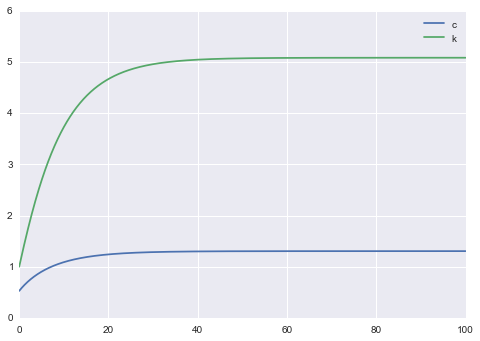

In [28]:
# plot the solution
visualizer.interpolation_knots = np.linspace(domain[0], domain[1], N)
visualizer.solution.plot()
plt.show()

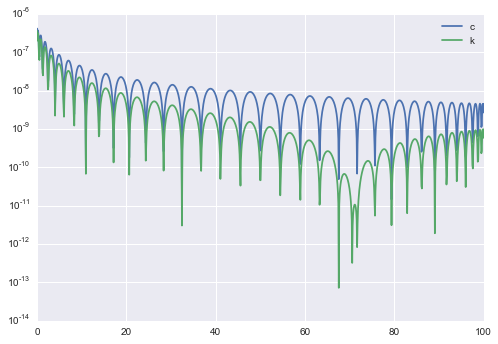

In [29]:
# plot the normalized residuals (they should be small everywhere!)
visualizer.normalized_residuals.plot(logy=True)
plt.show()